In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
df_violation = pd.read_csv('df_violation.csv')

In [3]:
df_violation.head()

,date,quantity
0,2006-01-01,49
1,2006-01-08,251
2,2006-01-15,246
3,2006-01-22,243
4,2006-01-29,218


In [4]:
df_violation['date'] = pd.to_datetime(df_violation['date'])

In [5]:
df_violation.set_index(['date'], inplace=True, drop=True)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


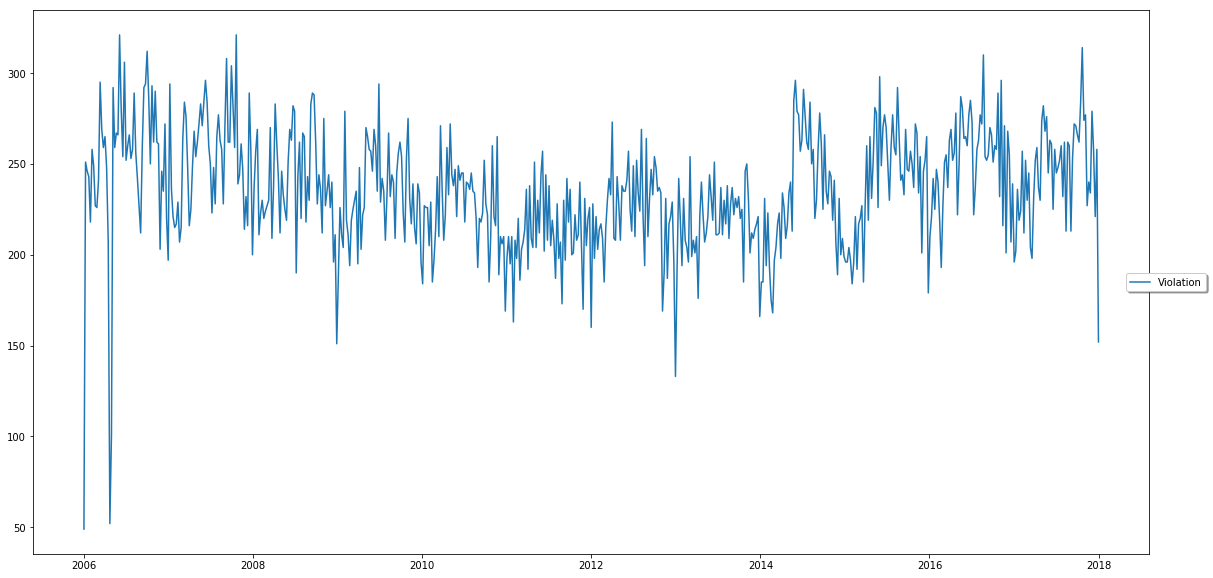

In [8]:
plt.figure(figsize=(20,10))
plt.plot(df_violation, label= 'Violation')
plt.legend(loc='center left', bbox_to_anchor=(0.975, 0.5), fancybox=True, shadow=True)

In [9]:
def correlationplot(y, lags=None, figsize=(12, 7), style='bmh'):
  
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

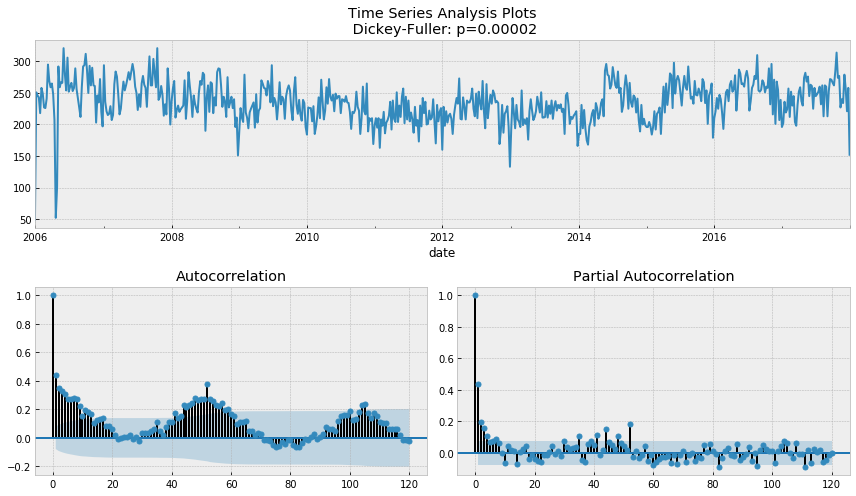

In [10]:
correlationplot(df_violation['quantity'], lags=120)

In [11]:
violation_diff = df_violation['quantity'] - df_violation['quantity'].shift(52)

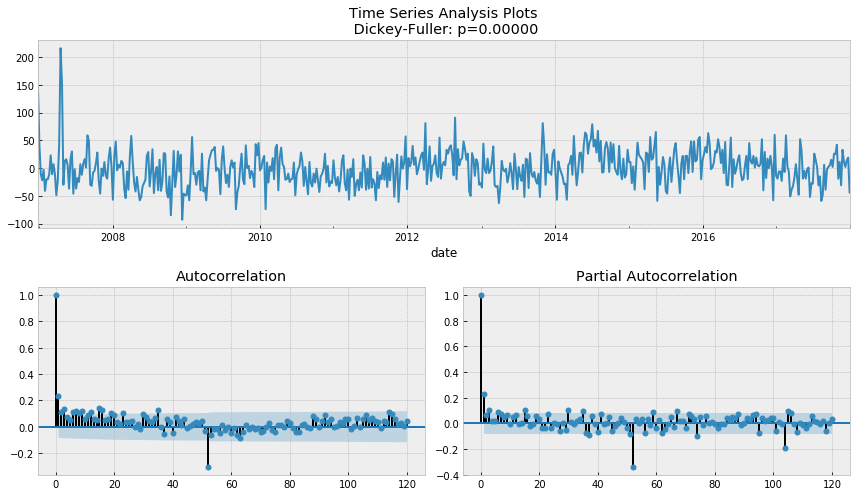

In [12]:
correlationplot(violation_diff[52:], lags=120)

In [13]:
violation_diff = violation_diff - violation_diff.shift(1)

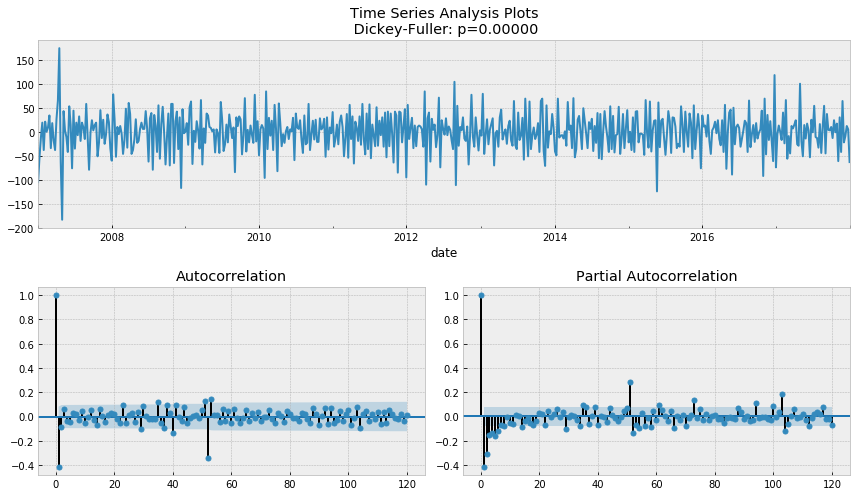

In [14]:
correlationplot(violation_diff[52+1:], lags=120)

In [16]:
ps = range(4,6)
d = range(1,2)
qs = range(1,2)
Ps = range(1,2)
D = range(1,2)
Qs = range(1,2)
s = 52

parameters = product(ps, d, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

2

In [17]:
parameters_list

[(4, 1, 1, 1, 1, 1), (5, 1, 1, 1, 1, 1)]

In [18]:
def optimizeSARIMA(dataframe, param_list, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm(param_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(dataframe, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [19]:
violation_train = df_violation[:(int(len(df_violation)*0.8))]
violation_test = df_violation[(int(len(df_violation)*0.8)):]

In [22]:
train_results = optimizeSARIMA(violation_train, parameters_list, s)
train_results

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


,parameters,aic
0,"(4, 1, 1, 1, 1, 1)",4285.179238
1,"(5, 1, 1, 1, 1, 1)",4286.680068


In [25]:
p, d, q, P, D, Q = train_results.parameters[0]

violation_best_model=sm.tsa.statespace.SARIMAX(violation_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
def plotSARIMAtraining(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    #train/test split
    data = series.copy()
    data_train = data[:(int(len(data)*0.8))]
    data_test = data[(int(len(data)*0.8)):]
    data_test.columns = ['actual']
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data_train.shape[0], end = data_train.shape[0]+n_steps-1)
    forecast = pd.DataFrame(forecast, columns=['arima_model'])
    forecast.dropna(inplace=True)
    arima_forecast = pd.concat([forecast, data_test], axis=1)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(arima_forecast['actual'], arima_forecast['arima_model'])
    
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    #plt.plot(series, color='b', label='actual')
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data_test.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data, label="actual")
    plt.legend()
    plt.grid(True);

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


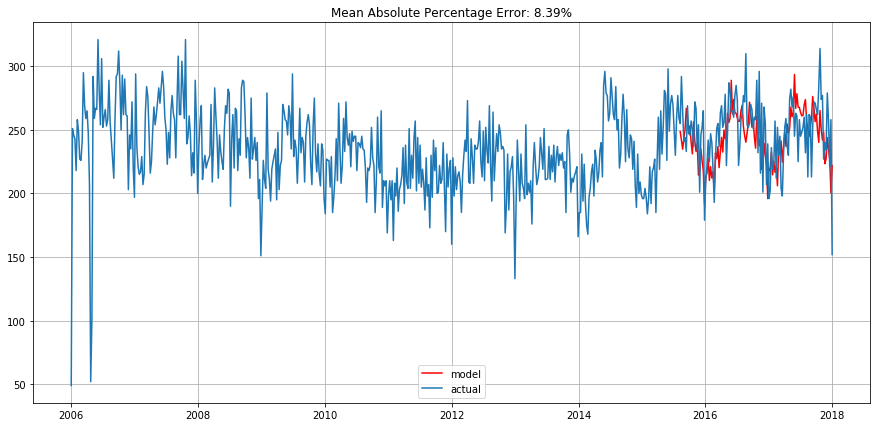

In [28]:
plotSARIMAtraining(df_violation, violation_best_model, 126)

In [31]:
p, d, q, P, D, Q = train_results.parameters[0]

violation_final_model=sm.tsa.statespace.SARIMAX(df_violation, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [32]:
def plotSARIMA(series, model, n_steps):
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, dynamic=True)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast[data.shape[0]:], color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


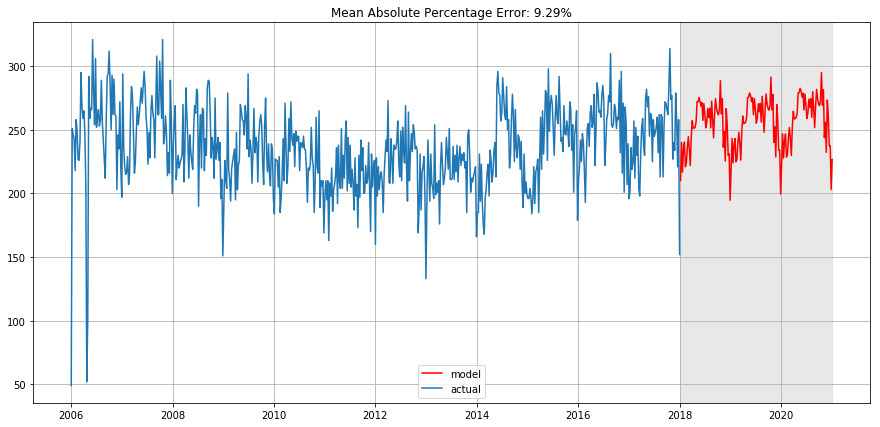

In [33]:
plotSARIMA(df_violation, violation_final_model, 156)

In [34]:
def saveforecasts(series, model, n_steps):
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, dynamic=True)
    forecast = data.arima_model.append(forecast)
    
    return forecast[data.shape[0]:]

In [35]:
violation_forecast = pd.DataFrame(saveforecasts(df_violation, violation_final_model, 156), columns=['quantity'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
violation_forecast.to_csv('violation_forecast.csv')

In [38]:
df_violation.to_csv('df_violation.csv')